In [4]:
# 공통 라이브러리
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

def evaluate_clustering(X, labels, name):
    """내부 지표 평가 함수"""
    mask = labels != -1
    if len(set(labels[mask])) <= 1:
        print(f"{name}: too few clusters for metrics.")
        return
    sil = silhouette_score(X[mask], labels[mask])
    dbi = davies_bouldin_score(X[mask], labels[mask])
    chi = calinski_harabasz_score(X[mask], labels[mask])
    print(f"[{name}] Silhouette={sil:.3f}, DBI={dbi:.3f}, CHI={chi:.1f}")

    # 2D 시각화
    Z = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(5,4))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=8)
    plt.title(f"{name} | Sil={sil:.2f} | DBI={dbi:.2f}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

## 1) Silhouette Coefficient -> 제일 많이 사용하고 표준 (느려서, 데이터 그면 표본 추출해서 보기도)
- 한 샘플 x가 속한 군집 내부에서 얼마나 잘 뭉쳐 있고, 가장 가까운 다른 군집과는 얼마나 멀리 떨어져 있는지를 동시에 본 값
- -1~1의 범위를 가짐, 1일 수록 좋은 상황 0은 경계에 있는 상황, 음수면 차라리 다른 군집인게 더 나은 상황 (잘못된 군집에 데이터가 있음)
## 2) Davies–Bouldin Index (DBI)
- 군집 내부 퍼짐(분산) 대비 군집 간 분리가 얼마나 좋은지에 대한 지표. 각 군집 i에 대해 “나와 가장 헷갈리는(가장 가깝고 내부 분산도 큰) 군집 j”와의 비율을 계산해 평균을 취함. 낮을 수록 좋음
## 3) Calinski–Harabasz Index (CHI, Variance Ratio Criterion) -> 빠
- 군집 간 분산(Between-Cluster Dispersion)을 군집 내 분산(Within-Cluster Dispersion)*로 나눈 값의 비율을 사용해 측정. 클수록 좋음.
## 4) 시각화 병행 (데이터가 복잡할 수록)

## K-Means – UCI Wholesale Customers

- 데이터 포인트를 K개의 군집 중심(centroid)으로부터의 거리로 나누는 방식.
- 계산 빠름
- k 값 미리 지정해야 함, 이상치에 취약

C:\Users\sju12\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[K-Means (Wholesale)] Silhouette=0.192, DBI=1.484, CHI=118.0


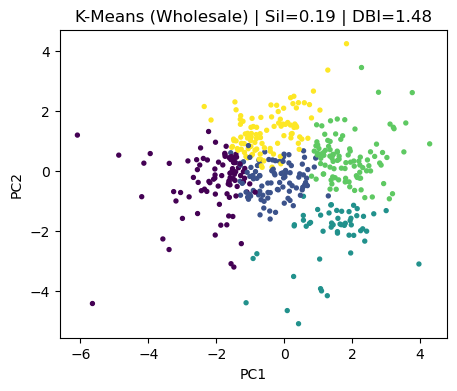

In [5]:
from sklearn.cluster import KMeans

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)
X = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']]
X_scaled = StandardScaler().fit_transform(np.log1p(X))

kmeans = KMeans(n_clusters=5, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels, "K-Means (Wholesale)")


## Gaussian Mixture Model – UCI Credit Card Default

- 각 군집을 정규분포(Gaussian)로 가정하고, 확률 기반으로 클러스터링.
- 소프트 클러스터링(한 데이터가 여러 군집에 속할 확률 계산) 가능 (K-Means보다 유연)
- 정규분포가 깨진다면? 성능 저하

In [8]:
# ! pip install xlrd

[GMM (CreditCard)] Silhouette=-0.002, DBI=3.820, CHI=2974.8


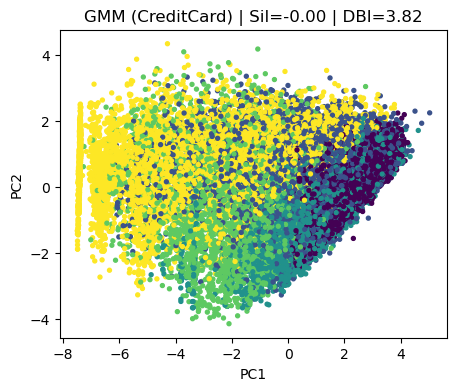

In [9]:
from sklearn.mixture import GaussianMixture

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
num_cols = ['LIMIT_BAL','AGE'] + [c for c in df.columns if c.startswith('BILL_AMT') or c.startswith('PAY_AMT')]
X = df[num_cols].clip(lower=0)
X_scaled = StandardScaler().fit_transform(np.log1p(X))

gmm = GaussianMixture(n_components=5, random_state=42)
labels = gmm.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels, "GMM (CreditCard)")


## DBSCAN – CitiBike Station
- 밀도가 높은 영역을 군집으로 정의하고, 희박한 영역은 노이즈(이상치)로 분류.
- 군집 개수를 몰라도 됨, 이상치 자동 탐지 가능
- 하이퍼 파라미터에 민감

[DBSCAN (CitiBike)] Silhouette=0.153, DBI=0.653, CHI=77.0


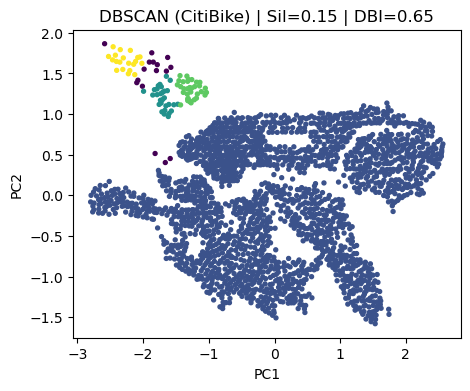

In [10]:
import requests
from sklearn.cluster import DBSCAN

url = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"
stations = requests.get(url, timeout=30).json()['data']['stations']
df = pd.DataFrame(stations)[['lat','lon']].dropna()

X_scaled = StandardScaler().fit_transform(df[['lat','lon']])
db = DBSCAN(eps=0.15, min_samples=8)
labels = db.fit_predict(X_scaled)

evaluate_clustering(X_scaled, labels, "DBSCAN (CitiBike)")


## Hierarchical → Credit Card Default
- 유사도가 높은 샘플끼리 병합(또는 분할)하면서 트리 형태(dendrogram)로 표현.
- 군집 개수를 미리 지정할 필요 없음, 트리 시각화로 관계 구조 파악 가능
- 대규모 데이터에 느림, 시각화 할 때 불편

[Hierarchical (Credit Card)] Silhouette=0.392, DBI=1.739, CHI=370.6


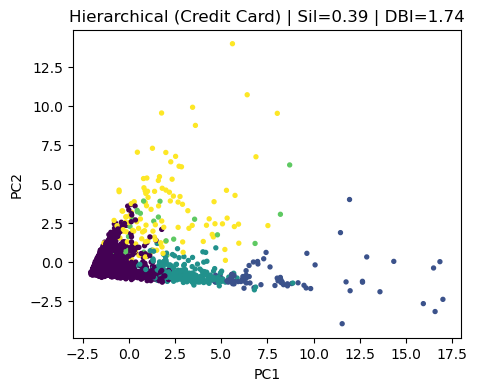

In [5]:
import pandas as pd, numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

num_cols = ['LIMIT_BAL','AGE'] + [c for c in df.columns if c.startswith('BILL_AMT') or c.startswith('PAY_AMT')]
cat_cols = []

# 샘플링 (속도 개선용)
df_sample = df.sample(2000, random_state=42)

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols)
])
X = pre.fit_transform(df_sample[num_cols])

Z = linkage(X, method='ward')
labels = fcluster(Z, t=5, criterion='maxclust')

evaluate_clustering(X, labels, "Hierarchical (Credit Card)")


In [7]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


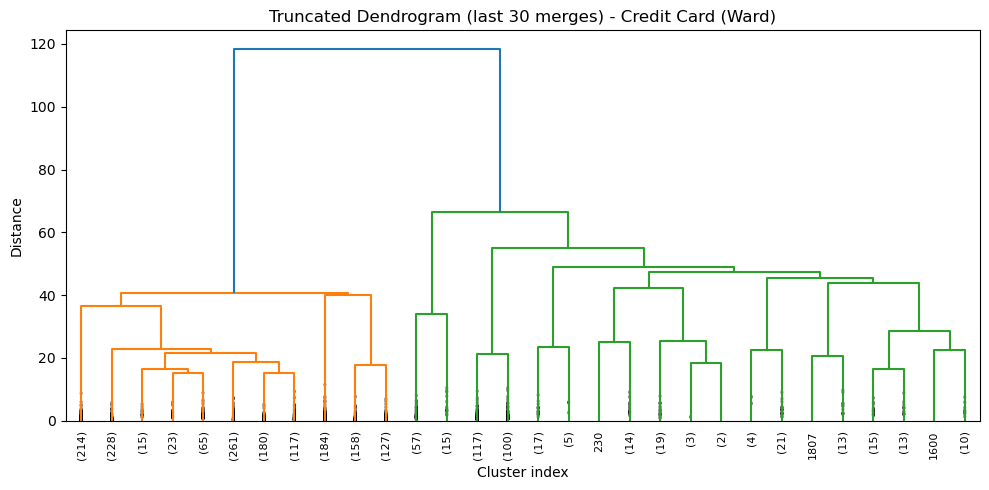

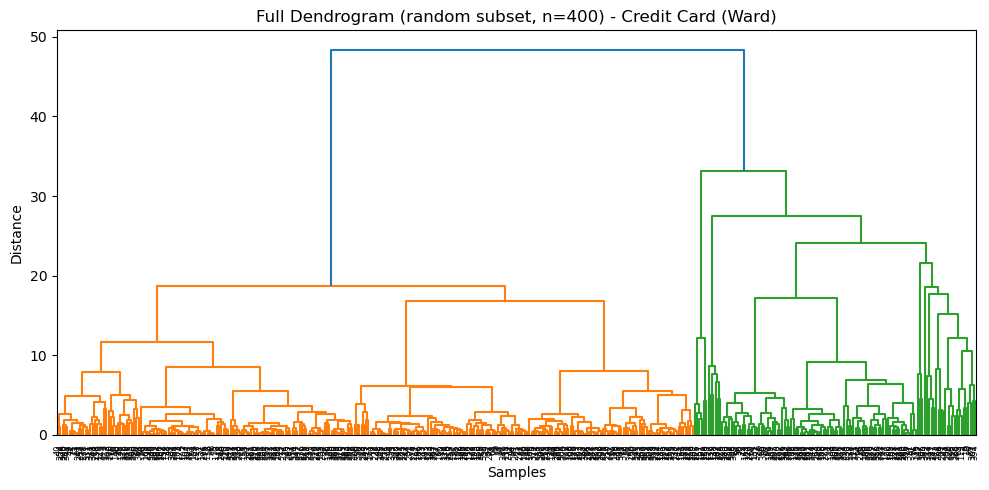

In [6]:
import matplotlib.pyplot as plt

# 1) 요약 덴드로그램 (truncate) - 마지막 병합 단계 기준 상위 p개 클러스터만 표시 (가독성↑)
plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode='lastp',  # 마지막 p개 클러스터만
    p=30,                   # 표시할 클러스터 수
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True    # 축약된 가지 표시
)
plt.title("Truncated Dendrogram (last 30 merges) - Credit Card (Ward)")
plt.xlabel("Cluster index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# 2) 전체 덴드로그램 - 완전한 덴드로그램이 필요하면, 랜덤 표본으로 그리기
sub_n = min(400, X.shape[0])  # 400개 정도가 가독성/속도 측면에서 현실적
sub_idx = np.random.choice(X.shape[0], size=sub_n, replace=False)
Z_sub = linkage(X[sub_idx], method='ward')

plt.figure(figsize=(10, 5))
dendrogram(
    Z_sub,
    leaf_rotation=90.,
    leaf_font_size=6.
)
plt.title(f"Full Dendrogram (random subset, n={sub_n}) - Credit Card (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [9]:
ddata = dendrogram(Z, no_plot=True)   # 그리지 않고 구조만 얻기
leaf_order = ddata["leaves"]          # 현재 덴드로그램의 리프 인덱스 순서
ordered_df = df_sample.iloc[leaf_order].copy()
ordered_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
22843,22844,50000,2,2,1,28,0,0,0,0,...,49158,50646,12927,2500,1900,1898,2386,629,792,1
9633,9634,50000,2,2,2,27,0,0,0,0,...,45227,29436,10363,2367,1606,1198,1196,343,154,0
17828,17829,50000,1,1,2,25,0,0,0,0,...,43451,19790,17790,1845,1967,1400,396,0,0,0
250,251,50000,2,2,2,26,1,2,2,0,...,30115,29527,29998,1710,136,1206,2002,2005,3003,0
29417,29418,50000,1,2,2,28,0,0,0,0,...,37211,28248,28430,2300,2000,1432,988,1600,1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6244,6245,280000,1,1,2,28,0,0,0,0,...,67554,-3,1244,80019,5000,439,10603,1247,2187,0
14847,14848,500000,2,2,1,48,0,0,0,0,...,130893,108030,144938,117243,4500,4500,5000,50000,4578,0
11514,11515,200000,1,2,1,34,0,0,0,0,...,170754,172332,175960,66022,6101,5898,6053,6288,8000,0
15693,15694,360000,1,1,2,29,0,0,0,0,...,213527,174907,126309,100000,8270,8423,6753,5139,5000,0


In [11]:
len(leaf_order)

2000